# Porject 07. Marketing Email Campaign

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, precision_score, recall_score

import xgboost as xgb

%matplotlib inline
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

# Table of Contents
  1. [Read Data](#read_data)
  2. [Exploratory Data Analysis](#exploratorydataanalysis)
  3. [Build Predictive Model](#buildpredictivemodel)
  4. [Question 1](#question1)
  5. [Question 2](#question2)
  6. [Question3(1)](#question3(1))
  7. [Question3(2)](#question3(2))
  8. [Question 4](#question4)

<a id='read_data'></a>
## Read Data

In [50]:
# read the email table and corresponding describe and statistical information
email = pd.read_csv('C:/Users/xiaoj/Desktop/CS/collection of data science-take home challenges/Data/7. email/email_table.csv',index_col = 'email_id')
email.head()

,email_text,email_version,hour,weekday,user_country,user_past_purchases
email_id,,,,,,
85120,short_email,personalized,2,Sunday,US,5
966622,long_email,personalized,12,Sunday,UK,2
777221,long_email,personalized,11,Wednesday,US,2
493711,short_email,generic,6,Monday,UK,1
106887,long_email,generic,14,Monday,US,6


In [51]:
email.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 85120 to 348333
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   email_text           100000 non-null  object
 1   email_version        100000 non-null  object
 2   hour                 100000 non-null  int64 
 3   weekday              100000 non-null  object
 4   user_country         100000 non-null  object
 5   user_past_purchases  100000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 5.3+ MB


In [52]:
email.describe()

,hour,user_past_purchases
count,100000.000000,100000.00000
mean,9.059300,3.87845
std,4.439637,3.19611
min,1.000000,0.00000
25%,6.000000,1.00000
50%,9.000000,3.00000
75%,12.000000,6.00000
max,24.000000,22.00000


In [53]:
# check if there are any NaN values
email.isnull().sum()

email_text             0
email_version          0
hour                   0
weekday                0
user_country           0
user_past_purchases    0
dtype: int64

In [54]:
#check the categories in categorical field
[email[x].nunique() for x in ['email_text','email_version','weekday','user_country']]

[2, 2, 7, 4]

In [55]:
# rename long column names to shorter and understandable ones to make it easier to manipulation
email.rename(columns = {'email_id':'id', 'email_text':'is_short', 'email_version':'is_personalized','user_country':'country', 'user_past_purchases':'purchases'},inplace=True)
email.head()

,is_short,is_personalized,hour,weekday,country,purchases
email_id,,,,,,
85120,short_email,personalized,2,Sunday,US,5
966622,long_email,personalized,12,Sunday,UK,2
777221,long_email,personalized,11,Wednesday,US,2
493711,short_email,generic,6,Monday,UK,1
106887,long_email,generic,14,Monday,US,6


In [56]:
# read the data in another two tables
open = pd.read_csv('C:/Users/xiaoj/Desktop/CS/collection of data science-take home challenges/Data/7. email/email_opened_table.csv')
open.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [57]:
click = pd.read_csv('C:/Users/xiaoj/Desktop/CS/collection of data science-take home challenges/Data/7. email/link_clicked_table.csv')
click.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


<a id='question1'></a>
## Question 1
What percentage of users opened the email and what percentage clicked on the link within the email?

In [58]:
#calculate percentage of users opened the email
open_percentage = open.shape[0]/email.shape[0]
open_percentage

0.10345

In [59]:
# calculate percentage of users clicked on the link within the email 
click_percentage = click.shape[0]/email.shape[0]
click_percentage

0.02119

In [60]:
print("{:.2f}% of users opened the email".format(open_percentage * 100))
print("{:.2f}% of users clicked the link".format(click_percentage * 100))

10.35% of users opened the email
2.12% of users clicked the link


<a id='exploratorydataanalysis'></a>
## Exploratory Data Analysis

In [61]:
# add a new column to email table
email['final'] = 'received'
email.loc[open['email_id'],'final'] = 'opened'
email.loc[click['email_id'],'final'] = 'clicked'
email.head()

,is_short,is_personalized,hour,weekday,country,purchases,final
email_id,,,,,,,
85120,short_email,personalized,2,Sunday,US,5,received
966622,long_email,personalized,12,Sunday,UK,2,clicked
777221,long_email,personalized,11,Wednesday,US,2,received
493711,short_email,generic,6,Monday,UK,1,received
106887,long_email,generic,14,Monday,US,6,received


In [62]:
# to define functions that can be generally applied to the various features when chek their influence on final click rate
def final_ratio(data):
    final_counts = data['final'].value_counts(normalize = True)
    return final_counts

def feature_plot(column):
    feature_inf = email.groupby(column).apply(final_ratio)
    feature_inf.loc[:,'clicked'].plot(kind='bar')
    plt.ylabel('Click Ratio')
    plt.xlabel(column)
    plt.xticks(rotation=0)
    plt.title('Click Ratio vs.{}'.format(column))
    return feature_inf

final,received,opened,clicked
is_short,,,
long_email,0.908266,0.073196,0.018538
short_email,0.883698,0.092430,0.023872


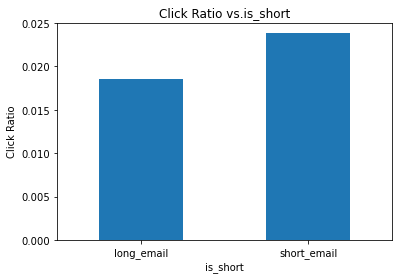

In [63]:
# check if 'email text' is short has influence on final click rate
feature_plot('is_short')

People prefer short emails which induce higher click rate. People prefer simple and shorter sensences to save their time and energy.

final,received,opened,clicked
is_personalized,,,
generic,0.920034,0.064829,0.015137
personalized,0.871864,0.100842,0.027294


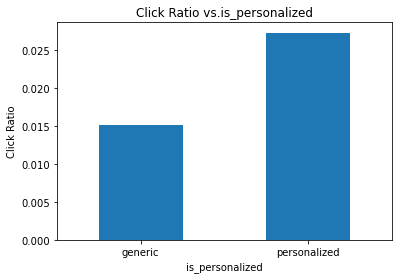

In [64]:
# check if personlized email will produce more click rate
feature_plot('is_personalized')

Personliazed email has absolutely great infulence. It showed 1.8 times higher click rate compared with general email does.

final,received,opened,clicked
weekday,,,
1,0.883590,0.093504,0.022906
2,0.879092,0.096019,0.024889
3,0.879296,0.093084,0.027620
4,0.881348,0.094207,0.024445
5,0.925019,0.060944,0.014037
6,0.912005,0.070149,0.017846
7,0.911448,0.071801,0.016751


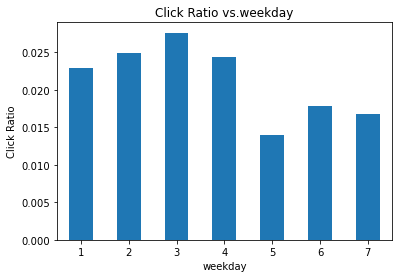

In [65]:
# check if weekday has relationship with click rate
weekday_to_index={'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
email['weekday'] = email['weekday'].map(weekday_to_index)
feature_plot('weekday')

On Friday,Saturday and sunday,there are obviously lower'click rate' than other days.This does make sense since people normaly don't like to process emails during weekends.

final,received,opened,clicked
country,,,
ES,0.960570,0.031103,0.008327
FR,0.958779,0.033217,0.008004
UK,0.879282,0.096043,0.024675
US,0.880481,0.095160,0.024360


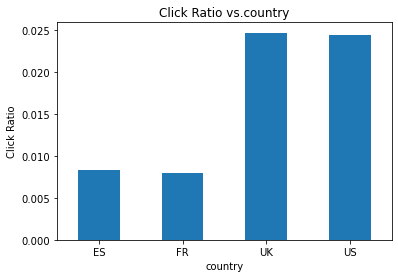

In [66]:
# check if country has influence on click rate
feature_plot('country')

UK and US has obviously higher click rates compared to the other two countries.

This may be caused by the language. If the email are written in English, those whose english are not good enough won't understand it, which lead to lower click rate. 

In [67]:
# check if sending time has relationship with click rate
hour_inf = email.groupby("hour").apply(final_ratio).unstack()
hour_inf.fillna(value=0,inplace=True)
hour_inf
#hour_inf.loc[:,'final'].plot(kind='bar')

,clicked,opened,received
hour,,,
1,0.018128,0.071032,0.910840
2,0.016322,0.072089,0.911589
3,0.019523,0.065293,0.915184
4,0.016186,0.072394,0.911419
5,0.018013,0.064570,0.917417
6,0.017147,0.073677,0.909176
7,0.018284,0.072282,0.909434
8,0.018933,0.069659,0.911407
9,0.025794,0.100481,0.873725


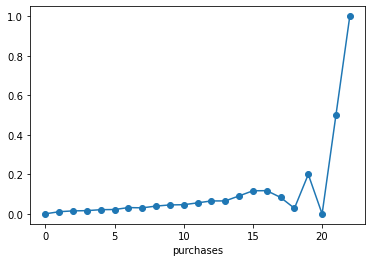

In [68]:
# check how users'past purchases influence the final click rate
purchase_inf = email.groupby("purchases").apply(final_ratio).unstack()
purchase_inf.fillna(value=0,inplace=True)
purchase_inf.loc[:,'clicked'].plot(kind='line',marker='o')

It can be found that the more items a user purchased previously, the more likely that user will open the email and click it.

### Chi2-test
After the analysis on the individual segments of email, I will do the Chi-squre test to see which segment is more important and more reated to the final click rate compared with others.

In [69]:
# Chi2-test
X = email.copy()
X['final'] = LabelEncoder().fit_transform(X['final'])
X['is_short'] = LabelEncoder().fit_transform(X['is_short'])
X['is_personalized'] = LabelEncoder().fit_transform(X['is_personalized'])
X['country'] = LabelEncoder().fit_transform(X['country'])
x = X.drop(columns='final')
y = X['final']

chi2score,pvalue = chi2(x,y)
pd.DataFrame({'chi2score':chi2score},index = X.drop(columns='final').columns).sort_values(by='chi2score',ascending=False)

,chi2score
purchases,3448.795660
country,378.554465
is_personalized,316.752872
weekday,210.006087
hour,147.815921
is_short,81.527600


From the **chi2** test, it can be fount that:
- The most important feature that influence the final click rate is if the users has the past-purchase experience or not;

- The second most important features are country and email's version;

- The less features are weekday,hour and if the email text is short or long.


<a id='question4'></a>
## Question 4
Any interesting pattern on how the email campaign performed for different segments of users? Explain.

From the above analysis, it can be found that:
- Users_past_purchase is the most important feature.

- Country also play a vital role in determining final click rate. UK and US are the most likely to click the link.

- Personalized emails are more likely to be opened and linked.

- The other features are not so important. But there are still some patterns we can follow, For example, people prefer short emails. On weekends, there are more click rate.

## Build Predictive Model
Build a model to predict whether a user will open the email and click the link inside it.

### Prepare the data

In [70]:
email1 = email.copy()
email1.head()

,is_short,is_personalized,hour,weekday,country,purchases,final
email_id,,,,,,,
85120,short_email,personalized,2,7,US,5,received
966622,long_email,personalized,12,7,UK,2,clicked
777221,long_email,personalized,11,3,US,2,received
493711,short_email,generic,6,1,UK,1,received
106887,long_email,generic,14,1,US,6,received


In [71]:
# transfer the previous categorical field into numerical field
email1['is_short'] = (email1['is_short']=='short_email').astype(np.int)

email1['is_personalized'] = (email1['is_personalized']=='personalized').astype(np.int)

In [72]:
# select features
X = email1.reindex(columns=['purchases','country','is_personalized','is_short'])

# create new feature
X['is_weekend'] = (email1['weekday']>=5).astype(int)

# One-Hot-Encode 'country' feature
X = pd.get_dummies(X, columns=['country'], drop_first=True)

# prepare the target
y = (email1['final']=='clicked').astype(int)

X.head()

,purchases,is_personalized,is_short,is_weekend,country_FR,country_UK,country_US
email_id,,,,,,,
85120,5,1,1,1,0,0,1
966622,2,1,0,1,0,1,0
777221,2,1,0,0,0,0,1
493711,1,0,1,0,0,1,0
106887,6,0,0,0,0,0,1


In [73]:
# split for training and testing
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42,stratify=y)
print('Train positive ratio={:.3f}'.format(ytrain.mean()))
print('Test positive ratio={:.3f}'.format(ytest.mean()))

Train positive ratio=0.021
Test positive ratio=0.021


From the above results, it can be found it's an imbalanced data.

### Train the model

In [74]:
# Due to the time limitation, I will just train one GBM model.
# If given sufficient time, I will apply following strategies to improve the model"
# For example, build multiple models, and ensemble them (average or stacking) to improve the predictive performance.
# try more hyper_parameters to find better ones.
train_matrix = xgb.DMatrix(xtrain, ytrain)
test_matrix = xgb.DMatrix(xtest)

In [75]:
params = {'eta':0.1,
          'subsample':0.8,
          'max_depth':6,
          'colsample_bytree':0.8,
          'scale_pos_weight':7,
          'objective':'binary:logistic',
          'eval_metric':'auc'}
xgb.cv(params, 
       train_matrix, 
       num_boost_round=300, 
       nfold=5, 
       early_stopping_rounds=10, 
       seed=42)

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.635124,0.003925,0.629237,0.013160
1,0.698144,0.045007,0.680497,0.049597
2,0.717900,0.035657,0.700988,0.036446
3,0.737558,0.007595,0.717995,0.014693
4,0.744811,0.003343,0.728116,0.010341
5,0.748163,0.001669,0.731180,0.007769
6,0.749900,0.001086,0.732668,0.008401
7,0.751234,0.001493,0.734383,0.007429
8,0.752353,0.002133,0.734671,0.007219
9,0.752943,0.001966,0.734412,0.007652


In [76]:
cv_result=xgb.cv(params, 
       train_matrix, 
       num_boost_round=300, 
       nfold=5, 
       early_stopping_rounds=10, 
       seed=42,
       verbose_eval=True)

[0]	train-auc:0.63512+0.00392	test-auc:0.62924+0.01316
[1]	train-auc:0.69814+0.04501	test-auc:0.68050+0.04960
[2]	train-auc:0.71790+0.03566	test-auc:0.70099+0.03645
[3]	train-auc:0.73756+0.00760	test-auc:0.71800+0.01469
[4]	train-auc:0.74481+0.00334	test-auc:0.72812+0.01034
[5]	train-auc:0.74816+0.00167	test-auc:0.73118+0.00777
[6]	train-auc:0.74990+0.00109	test-auc:0.73267+0.00840
[7]	train-auc:0.75123+0.00149	test-auc:0.73438+0.00743
[8]	train-auc:0.75235+0.00213	test-auc:0.73467+0.00722
[9]	train-auc:0.75294+0.00197	test-auc:0.73441+0.00765
[10]	train-auc:0.75333+0.00187	test-auc:0.73483+0.00799
[11]	train-auc:0.75316+0.00203	test-auc:0.73481+0.00860
[12]	train-auc:0.75358+0.00189	test-auc:0.73495+0.00844
[13]	train-auc:0.75424+0.00132	test-auc:0.73516+0.00870
[14]	train-auc:0.75472+0.00129	test-auc:0.73501+0.00833
[15]	train-auc:0.75466+0.00131	test-auc:0.73511+0.00848
[16]	train-auc:0.75484+0.00135	test-auc:0.73542+0.00832
[17]	train-auc:0.75502+0.00168	test-auc:0.73514+0.00827
[1

In [77]:
n_best_trees = cv_result.shape[0]
n_best_trees

38

In [78]:
watchlist=[(train_matrix,'train')]
gbt = xgb.train(params,train_matrix,cv_result.shape[0],watchlist)

[0]	train-auc:0.63430
[1]	train-auc:0.72807
[2]	train-auc:0.71563
[3]	train-auc:0.73467
[4]	train-auc:0.73649
[5]	train-auc:0.74294
[6]	train-auc:0.74577
[7]	train-auc:0.74589
[8]	train-auc:0.74751
[9]	train-auc:0.74732
[10]	train-auc:0.74835
[11]	train-auc:0.74900
[12]	train-auc:0.74840
[13]	train-auc:0.74834
[14]	train-auc:0.74863
[15]	train-auc:0.74994
[16]	train-auc:0.75194
[17]	train-auc:0.75244
[18]	train-auc:0.75264
[19]	train-auc:0.75347
[20]	train-auc:0.75336
[21]	train-auc:0.75311
[22]	train-auc:0.75323
[23]	train-auc:0.75367
[24]	train-auc:0.75419
[25]	train-auc:0.75457
[26]	train-auc:0.75453
[27]	train-auc:0.75460
[28]	train-auc:0.75488
[29]	train-auc:0.75487
[30]	train-auc:0.75493
[31]	train-auc:0.75506
[32]	train-auc:0.75514
[33]	train-auc:0.75549
[34]	train-auc:0.75540
[35]	train-auc:0.75538
[36]	train-auc:0.75556
[37]	train-auc:0.75585


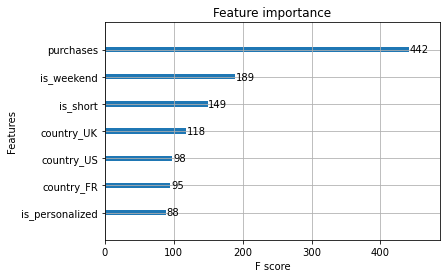

In [79]:
xgb.plot_importance(gbt)

In [88]:

ytest_predo = gbt.predict(test_matrix, ntree_limit=n_best_trees)
from sklearn.metrics import roc_auc_score
roc_auc_score(ytest, ytest_predo)

0.7394678648384236

In [98]:
ypreds = np.where(ytest_pred> best_threshold,1,0)
roc_auc_score(ytest, ypreds)

0.6695678245388436

### Plot ROC curve and choose better probability threshold
Since the data is highly imbalanced,if using default probability threshold(0.5), the model will classify every example as negative. So a better probability threshold should be chosen.

In [80]:
# split the previous train data to train and validation data, and use the validation data to find the best threshold 
xtrain_new, xvalid, ytrain_new, yvalid = train_test_split(xtrain,ytrain, test_size=0.2,random_state=42)

train_new_matrix = xgb.DMatrix(xtrain_new, ytrain_new)
valid_matrix = xgb.DMatrix(xvalid)

# retrain the new train data
gbt_new = xgb.train(params, train_new_matrix, n_best_trees)

# predict on validation set
yvalid_probas = gbt_new.predict(valid_matrix, ntree_limit = n_best_trees)

Text(0, 0.5, 'TPR')

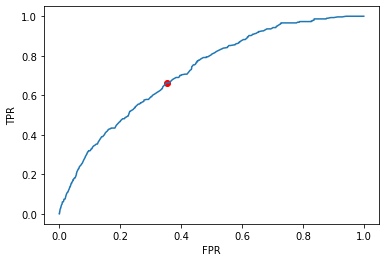

In [81]:
# plot the roc curve and find the threshold which is nearest to the left-top of the ROC curve
fpr,tpr,thresholds=roc_curve(yvalid,yvalid_probas)

gmeans=np.sqrt(tpr*(1-fpr))
i_max=np.argmax(gmeans)

plt.plot(fpr,tpr)
plt.scatter(fpr[i_max],tpr[i_max],marker='o',color='red',label='Best Threshold')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [82]:
best_threshold = thresholds[i_max]
print('Best Threshold: {:.3f}'.format(thresholds[i_max]))

Best Threshold: 0.152


<a id='question3(1)'></a>
## Question 3 (1)
How much do you think your model would improve click through rate? 

In [100]:
# adjust the prediction
ytest_pred = gbt_new.predict(test_matrix, ntree_limit = n_best_trees)
#ytest_pred = (ytest_pred > best_threshold).astype(int)
preds = np.where(ytest_pred> best_threshold,1,0)
#print (classification_report(ytest, ytest_pred))
print (classification_report(ytest,preds))

              precision    recall  f1-score   support

           0       0.99      0.67      0.80     32301
           1       0.04      0.67      0.08       699

    accuracy                           0.67     33000
   macro avg       0.52      0.67      0.44     33000
weighted avg       0.97      0.67      0.78     33000



In [93]:
b=pd.DataFrame()
b['aa']=ytest_pred
b['bb']=preds
b

,aa,bb
0,0.236220,1
1,0.082838,0
2,0.319803,1
3,0.082247,0
4,0.059839,0
...,...,...
32995,0.077056,0
32996,0.196711,1
32997,0.174287,1
32998,0.112874,0


In [86]:

roc_auc_score(ytest, ytest_pred)

0.7355595274935126

In [89]:
roc_auc_score(ytest, preds)

0.6695678245388436

In [102]:
# check the Precision and Recall
print ('New_Test_Precision: {:.2f}%'.format(precision_score(ytest, preds) * 100))
print ('New_Test_Recall: {:.2f}%'.format(recall_score(ytest, ytest_pred) * 100))

New_Test_Precision: 4.20%


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [48]:
gbt.save_model('gbt.model')

<a id='question2'></a>
## Question 2
Build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email.

I just built a Gradient Boosting Tree model in previous section which predicts whether a user will click the link or not. The new email campaign strategy will only send emmail to uses which my model predicts positive.

In [154]:
old_emails_sent = ytest_pred.shape[0]
new_email_sent = ytest_pred.sum()
saving_percentage = 100 - new_email_sent * 100.0/old_emails_sent

print('Previous emails sent: {:.2f} '.format(old_emails_sent))
print('New emails sent: {:.2f} '.format(new_email_sent))
print('Saving percentage: {:.2f} '.format(saving_percentage))

Previous emails sent: 33000.00 
New emails sent: 11140.00 
Saving percentage: 66.24 


According to the predictive result on test set:
- 4.20% of the receivers will open email and click the link. By compared with old strategy, whose click rate is 2.12%, my new strategy can double the click rate.
- my model saved 66.2% amount, and only need to 33.8% of the old email amount.
- my model will cover 67% valued users which click the link.

<a id='question3(2)'></a>
## Question 3 (2)
How would you test that?

To test my conclusion, we need to perform a A/B test:
1. Randomly assign users to two groups, control and experimental group.
2. In control group,user still use the old email-campaign strategy,i.e.,just send emails to all users in control group.
3. In experiment group,use the model I built to predict whether the user will click the link r not, and only send emails to those users whose predictive result is positive.
4. Perform a one-taill t-test to test whether experiment group's population proportion is higher than control groups's.